# Assignment 1 | FIT 5202 - Data processing for Big Data


Student: Cristiana Garcia de Freitas

ID: 3008887

## PART A: Analysing Text Data

### Step 01: Import pyspark and initialize Spark

In [1]:
# create entry points to spark
from pyspark import SparkContext, SparkConf # Spark
from pyspark.sql import SparkSession # Spark SQL

# We add this line to avoid an error : "Cannot run multiple SparkContexts at once". 
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

# Construct a configuration
conf = SparkConf()

# The `appName` field is a name to be shown on the Sparking cluster UI. 
conf.set("spark.app.name", "Assignment 1 FIT 5202")
# local[*]: run Spark locally with as many working processors as logical cores on your machine.
# In the field of `master`, we use a local server with as many working processors (or threads) as possible (i.e. `local[*]`). 
conf.set("spark.master", "local[*]")

# If there is no existing spark context, we now create a new context
if (sc is None):
    sc = SparkContext(conf=conf)
spark = SparkSession(sparkContext=sc)

### Step 02: Create Resilient Distributed Datasets (RDDs)
Read the required dataset and display the total number of lines in each dataset

- Book1: "Agile Processes  in Software Engineering  and Extreme Programming.txt"
- Book2: "Scrum Handbook.txt

In [2]:
# reading the datasets
rdd1 = sc.textFile('data/Agile Processes  in Software Engineering  and Extreme Programming.txt')
rdd2 = sc.textFile('data/Scrum Handbook.txt')

# # display total number of lines
print("Book 1 has %d lines" %rdd1.count())
print("Book 2 has %d lines" %rdd2.count())

Book 1 has 21569 lines
Book 2 has 4617 lines


### Step 03: Cleaning/Manipulating
Words should be counted independent of their case. So, you will have to change all words to lower case. Further, if there are any leading or trailing spaces on a line, it should be removed. Write a function that performs the following tasks on the RDDs: 

1. Removes all characters which are not alphabets except space(s).
2. Changes all upper case letters to lower case.
3. Removes all leading or trailing spaces. 

You can use the python module re for matching patterns. 

Finally, display the contents of the RDDs after applying the function.

In [3]:
from re import sub

def function_cleaning(line):
    # removes all characters which are not alphabets except space(s)
    line = sub('[^a-zA-Z\s]*', '', line)
    # Changes all upper case letters to lower case.
    line = line.lower()
    # Removes all leading or trailing spaces.
    line = line.strip()
    return line

In [4]:
# apply the function to each element of the first RDD
clean_rdd1 = rdd1.map(function_cleaning)
# display first 20 observations
clean_rdd1.take(20)

['lnbip',
 '',
 '',
 'i helen sharp',
 '',
 'tracy hall eds',
 '',
 'agile processes',
 'in software engineering',
 'and extreme programming',
 '',
 'th international conference xp',
 'edinburgh uk may',
 'proceedings',
 '',
 '',
 'springer open',
 '',
 '',
 '']

In [5]:
# apply the function to each element of the second RDD
clean_rdd2 = rdd2.map(function_cleaning)
# display first 20 observations
clean_rdd2.take(20)

['jeff sutherlands',
 '',
 'scrum handbook',
 '',
 '',
 '',
 '',
 'everything',
 'you need',
 'to know',
 'to start',
 '',
 'a scrum project',
 'in your',
 'organization',
 '',
 'scrum',
 '',
 'training',
 '']

### Step 04: Transforming the Data/Counting the words
Apply a transformation that will split each element of the RDD by its spaces and then create a word pairs for e.g.('agile', 1), ('handbook', 1). Then, count the frequency of each word and display the top 20 most frequent words.

#### Book 1

In [6]:
# Split into words and remove empty lines:
tokenize1 = clean_rdd1.flatMap(lambda line: line.split(" ")) \
.filter(lambda word: word != "")
# The words are the keys in (word, 1). Reducing by key we aggregate the same word and count how many times 
# it appears with our lambda function.
counts1 = tokenize1.map(lambda words: (words,1))\
.reduceByKey(lambda x,y: x+y)\
.sortBy(lambda x: x[1], ascending=False)
# display the top 20 most frequent words
counts1.take(20)

[('the', 8145),
 ('and', 3965),
 ('of', 3944),
 ('to', 3714),
 ('in', 3076),
 ('a', 2701),
 ('is', 1539),
 ('that', 1355),
 ('for', 1194),
 ('as', 1028),
 ('on', 1015),
 ('we', 975),
 ('with', 969),
 ('software', 922),
 ('this', 915),
 ('are', 784),
 ('agile', 748),
 ('it', 741),
 ('development', 737),
 ('was', 711)]

#### Book 2

In [7]:
# Split into words and remove empty lines:
tokenize2 = clean_rdd2.flatMap(lambda line: line.split(" "))\
.filter(lambda word: word != "")
# The words are the keys in (word, 1). Reducing by key we aggregate the same word and count how many times 
# it appears with our lambda function.
counts2 = tokenize2.map(lambda words: (words,1))\
.reduceByKey(lambda x,y: x+y)\
.sortBy(lambda x: x[1], ascending=False) 
# display the top 20 most frequent words
counts2.take(20)

[('the', 1238),
 ('of', 537),
 ('and', 534),
 ('to', 477),
 ('a', 451),
 ('scrum', 395),
 ('in', 360),
 ('is', 348),
 ('team', 260),
 ('product', 232),
 ('for', 195),
 ('that', 181),
 ('it', 165),
 ('on', 149),
 ('sprint', 146),
 ('this', 142),
 ('with', 132),
 ('as', 124),
 ('are', 119),
 ('by', 118)]

### Step 05: Removing Stop Words 
In computing, stop words are words which are filtered out before or after processing of natural language data.
In natural language processing, use less words (data), are referred to as stop words. We would not want these words taking up space in our data base, or taking up valuable processing time. For this, we can remove them easily, by storing a list of words that you consider to be stop words.
NLTK (Natural Language Toolkit) in python has a list of stopwords stored in 16 different languages. 
Write the code to remove stop words from the RDDs. You should use nltk package to remove the stop words. Also find how many unique words do we now have in each RDD?

In [8]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Error loading stopwords: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>


#### Book 1
##### Removing stop words

In [9]:
filtered1 = counts1.filter(lambda word: word[0] not in stop_words)
filtered1.take(20)

[('software', 922),
 ('agile', 748),
 ('development', 737),
 ('team', 554),
 ('product', 451),
 ('work', 384),
 ('teams', 363),
 ('project', 354),
 ('developers', 343),
 ('research', 317),
 ('data', 311),
 ('process', 308),
 ('one', 288),
 ('also', 281),
 ('time', 281),
 ('study', 270),
 ('use', 269),
 ('code', 248),
 ('used', 244),
 ('startups', 230)]

##### Counting unique words

In [10]:
unique1 = filtered1.count()
print("Book 1 has %d unique words" %unique1)

Book 1 has 9611 unique words


#### Book 2
##### Removing stop words

In [11]:
filtered2 = counts2.filter(lambda word: word[0] not in stop_words)
filtered2.take(20)

[('scrum', 395),
 ('team', 260),
 ('product', 232),
 ('sprint', 146),
 ('development', 98),
 ('teams', 94),
 ('project', 92),
 ('owner', 85),
 ('work', 79),
 ('backlog', 74),
 ('one', 65),
 ('software', 52),
 ('management', 52),
 ('items', 52),
 ('new', 51),
 ('jeff', 48),
 ('time', 45),
 ('release', 44),
 ('meeting', 44),
 ('first', 40)]

##### Counting unique words

In [12]:
unique2 = filtered2.count()
print("Book 2 has %d unique words" %unique2)

Book 2 has 2936 unique words


### Step 06: Find the average occurrence of a word 
To find the average occurrence of a word, you will have to find the total number of words and divide that by the number of unique words. Write the code to find the average occurrences of the words.

In [13]:
# average_words = total_words/unique_words
# Book 1:
total1 = filtered1.values().sum()
average1 = total1/unique1
print("Book 1 has %.2f average occurence of a word" %average1)
# Book 2:
total2 = filtered2.values().sum()
average2 = total2/unique2
print("Book 2 has %.2f average occurence of a word" %average2)

Book 1 has 8.23 average occurence of a word
Book 2 has 3.68 average occurence of a word


### Step 7: Exploratory data analysis
Analyze the distribution of the words using the standard python library - matplotlib. 
Please make sure you are aware of the different factors such as:
visual effects,
coordinates ystem,
labels,
data type and scale and informative interpretation before data visualisation. Also consider other aspects of visualization like:
clarity,
accuracy
and efficiency as well.

Compare the distribution of words in Book1 and Book2. The data spans many orders of magnitude and the features of the distribution not quite evident in the linear space. Therefore, use logscale (base10) to plot the graph. Explain your understanding based on the graphs.

Compare the top 15 most common words in Book1 and Book2. Plot the graphs and explain your understanding of the graph.


In [14]:
# importing the library that is going to be used to plot the graphs
import matplotlib.pyplot as plt

### Distribution of Words:

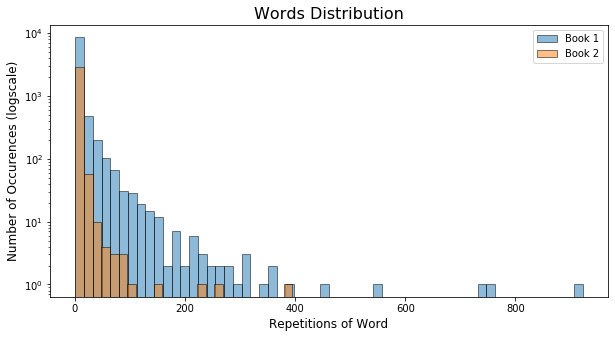

In [15]:
# input data for the histograms:
hist1 = filtered1.map(lambda x: x[1]).collect()
hist2 = filtered2.map(lambda x: x[1]).collect()

# Ploting the histograms: 
plt.figure(figsize=(10,5))
plt.hist(hist1, bins=58, label= "Book 1", alpha=0.5, edgecolor='black')
plt.hist(hist2, bins=25, label= "Book 2", alpha=0.5, edgecolor='black')
plt.yscale('log')
plt.xlabel('Repetitions of Word', fontsize=12)
plt.ylabel('Number of Occurences (logscale)', fontsize=12)
plt.title('Words Distribution', fontsize=16)
plt.legend(loc='upper right')
plt.show()

<font color=red><b>Answer:</font></b> <font color=blue><b>
We can see in the histogram above that both distributions of words frequencies are right skewed. They present a greater frequency in the occurence of words that are repeated a small number of times, as the bars are higher at the left side of the graph. Book one is more than 4 times longer than book 2 in terms of lines quantity, so, it's natural that, having more words written, book 2 have a higher number of occurences in almost every bin. The log scale has been applied to make them more comparable. It is also notable that very few words are repeated more than 400 times (and it only happens for book 2).</font></b> 

### Comparing top 15 most common words

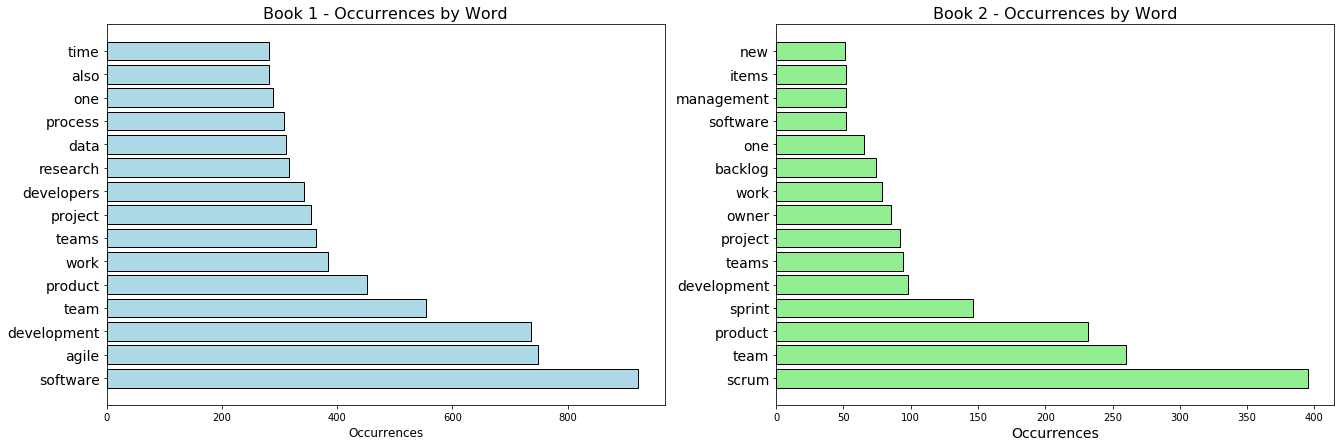

In [16]:
# preparing data for the plot regarding book1
top_book1 = filtered1.sortBy(lambda x: x[1], ascending=False).map(lambda x: x[1]).take(15)
legends1 = filtered1.sortBy(lambda x: x[1], ascending=False).map(lambda x: x[0]).take(15)
# preparing data for the plot regarding book2
top_book2 = filtered2.sortBy(lambda x: x[1], ascending=False).map(lambda x: x[1]).take(15)
legends2 = filtered2.sortBy(lambda x: x[1], ascending=False).map(lambda x: x[0]).take(15)

# plotting
fig, axes = plt.subplots(ncols=2, figsize=(22,7))
axes[0].barh(legends1, top_book1, align='center', color='lightblue', edgecolor='black')
axes[0].set_xlabel('Occurrences', fontsize=12)
axes[0].set_title('Book 1 - Occurrences by Word', fontsize=16)
axes[0].tick_params(axis = 'y', which = 'major', labelsize = 14)
axes[1].barh(legends2, top_book2, align='center', color='lightgreen', edgecolor='black')
plt.xlabel('Occurrences', fontsize=14)
plt.title('Book 2 - Occurrences by Word', fontsize=16)
plt.yticks(size=14)
plt.show()

<font color=red><b>Answer:</font></b> <font color=blue><b>
The most frequent word of Book 1 is "software", with over 800 occurences. It does also appear between the top 15 words of book 2, but only around 50 times. The top word of Book 2 is "scrum", with around 400 occurences. It does not appear between the top 15 words of Book 1.
    
Overall, the top words of both boths have a significant intersection (for instance: software, development, work, team, product...). 

One point that call attention is the presence of both "team" and "teams" in the two groups. Probably a part of those "teams" came from the removal of the apostrophe of "team's" in the cleaning stage. With further stemming and lemmatization these words would be analysed togheter and probably become the top word of the two books.
</font></b> 